# Edge dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
import os
import time
path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/"

#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
#load in dataset as compressed numpy (for storage) 
X_=np.load(datapath+"X_edge.npz")
for array_name in X_:
    X=X_[array_name].astype(np.uint8)
y_=np.load(datapath+"y_edge.npz")
for array_name in y_:
    y=y_[array_name].astype(np.uint8)

#relabel
y[y==7]=20 #20 degrees
y[y==4]=40 
y[y==11]=60 
#y[y==10]=240 
virginX=X.copy()
y_prime=np.zeros((len(y)*len(X[1])))
X_prime=np.zeros((len(X)*10,X.shape[2],X.shape[3]))
k=0
for i in range(len(X)): #create data aas linear images
    for j in range(len(X[0])):
        y_prime[k]=y[i]
        X_prime[k]=X[i][j]
        k+=1
X=X_prime
y=y_prime
X=X[:,10:110,10:110]
def applySobel(X):
    for i in range(len(X)): #crop all images individually
        image=X[i]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i]=sobel_combined

def augment(X,y):
    #create rotations
    AugmentedX=np.zeros((len(X)*3,*X.shape[1:]),dtype=np.uint8)
    Augmentedy=np.zeros_like(np.concatenate((y,y,y)))
    for k,i in enumerate(range(0,len(AugmentedX),3)): #loop through the normal data and new data
        AugmentedX[i]=np.copy(X[k])
        AugmentedX[i+1]=cv2.resize(cv2.rotate(X[k].copy(), cv2.ROTATE_90_CLOCKWISE),(X[k].shape[1],X[k].shape[0]),interpolation=cv2.INTER_AREA)
        AugmentedX[i+2]=cv2.resize(cv2.rotate(X[k].copy(), cv2.ROTATE_180),(X[k].shape[1],X[k].shape[0]),interpolation=cv2.INTER_AREA)
        Augmentedy[i+1]=y[k]+90
        Augmentedy[i+2]=y[k]+180
        Augmentedy[i]=y[k]
    #randomize order
    n_samples = AugmentedX.shape[0]
    indices = np.random.permutation(n_samples)
    shuffled_data = AugmentedX[indices]
    shuffled_labels = Augmentedy[indices]
    X=shuffled_data
    y=shuffled_labels
    return X,y
def addnoise(X,y):
    X=np.concatenate([X,X])
    y=np.concatenate([y,y])
    X[len(X):]+=np.random.normal(0,10,X[len(X):].shape)
    X[X<0]=0
    X[X>255]=255
    return X,y
#X,y=augment(X,y)
X,y=addnoise(X,y)
applySobel(X)
fig, axes = plt.subplots(1, 6, figsize=(15,5))
axes = axes.flatten()
print(X.shape,y.shape)
for i in range(6):
    im=axes[i].imshow(X[i],cmap="gray")
    #axes[i].axis("off")
    axes[i].set_xticks(np.arange(0, 110, 20))
    # Set custom ticks for y-axis (every 10 units)
    axes[i].set_yticks(np.arange(0, 110, 20))
    axes[i].tick_params(axis='x', colors='white')
    axes[i].tick_params(axis='y', colors='white')
    axes[i].grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/edgeExamplesAugmented.pdf")
plt.show()

(720, 100, 100)


IndexError: tuple index out of range

(720, 100, 100)


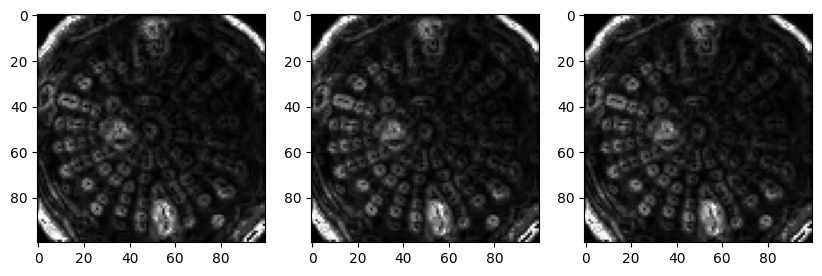

In [2]:
X=np.asarray(np.load(datapath+"X_edge.npy")).astype(np.uint8)
y=np.asarray(np.load(datapath+"y_edge.npy")).astype(np.uint8)
X40=X[np.where(y==40)]
X60=X[np.where(y==60)]
X20=X[np.where(y==20)]

print(X.shape)
fig, axes = plt.subplots(1, 3, figsize=(10,5))
axes = axes.flatten()
images=[X40[0],X60[0],X60[0]]
for i in range(3):
    axes[i].imshow(images[i],cmap="gray")
plt.show()

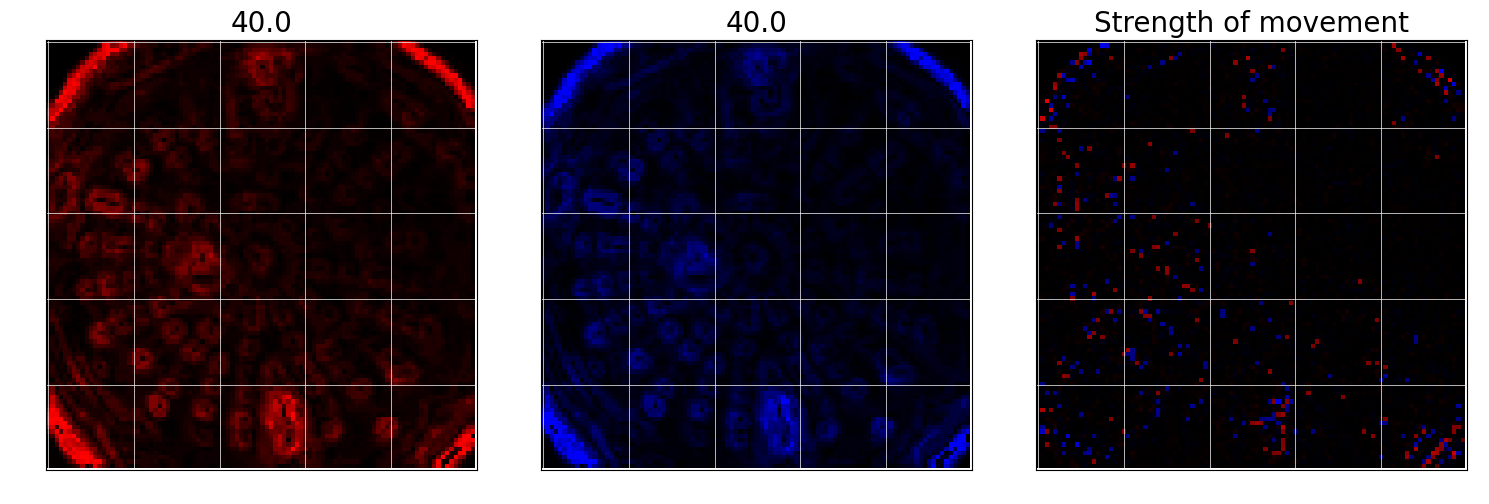

In [171]:
ind1=0
ind2=10
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.flatten()
image=np.zeros((*X[ind1].shape,3)).astype(np.uint8)
image[:,:,0]=X[ind1]
axes[0].imshow(image)
axes[0].set_title(y[ind1],fontsize=20)
axes[0].set_xticks(np.arange(0, 110, 20))
axes[0].set_yticks(np.arange(0, 110, 20))
axes[0].tick_params(axis='x', colors='white')
axes[0].tick_params(axis='y', colors='white')
axes[0].grid(True, which='both', axis='both', color='w', linestyle='-', linewidth=0.5)
image=np.zeros((*X[0].shape,3)).astype(np.uint8)
image[:,:,2]=X[ind2]
axes[1].imshow(image)
axes[1].set_title(y[ind2],fontsize=20)
axes[1].set_xticks(np.arange(0, 110, 20))
axes[1].set_yticks(np.arange(0, 110, 20))
axes[1].tick_params(axis='x', colors='white')
axes[1].tick_params(axis='y', colors='white')
axes[1].grid(True, which='both', axis='both', color='w', linestyle='-', linewidth=0.5)

image=np.zeros((*X[ind1].shape,3)).astype(np.int16)
image[:,:,0][np.where(X[ind1]>X[ind2])]=X[ind1][np.where(X[ind1]>X[ind2])]
image[:,:,2][np.where(X[ind1]<X[ind2])]=X[ind2][np.where(X[ind1]<X[ind2])]
image[:,:,2]-=X[ind1].astype(np.int16)
image[:,:,0]-=X[ind2].astype(np.int16)
image[:,:,0][image[:,:,0]>20]+=100
image[:,:,2][image[:,:,2]>20]+=100
image[image<0]=0

axes[2].imshow(image.astype(np.uint8))
axes[2].set_title("Strength of movement",fontsize=20)
axes[2].set_xticks(np.arange(0, 110, 20))
axes[2].set_yticks(np.arange(0, 110, 20))
axes[2].tick_params(axis='x', colors='white')
axes[2].tick_params(axis='y', colors='white')
axes[2].grid(True, which='both', axis='both', color='w', linestyle='-', linewidth=0.5)


plt.tight_layout()
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/combinedEdgeTTboth.pdf")
plt.show()

In [14]:
X40=X[np.where(y==40)]
X60=X[np.where(y==60)]
X20=X[np.where(y==20)]

print(X.dtype)
#histogram plot of different number of RB ppixels when comparing different edges. Is there something clear

uint8


## MOdelling

In [18]:
encoder = OneHotEncoder()  # sparse_output=False returns a dense array
# Fit and transform the label data
onehot_labels = encoder.fit_transform(y.reshape(-1, 1))
X_=X.reshape(len(X),-1).astype(np.uint8)
print(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X_, np.asarray(np.argmax(onehot_labels,axis=1)).astype(np.uint8), test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape,X_train.dtype)
# Standardize the features (important for SVM)
"""scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)"""

# Create an SVM classifier
svm_model = SVC(decision_function_shape='ovo')

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
y_pred2 = svm_model.predict(X_train)

y_pred = svm_model.predict(X_test)
y_pred2 = svm_model.predict(X_train)
loss=np.abs(y_pred2.reshape((y_pred2.shape[0],1))-y_train)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Accuracy train:",correct/len(loss))

loss=np.abs(y_pred.reshape((y_pred.shape[0],1))-y_test)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Accuracy test:",correct/len(loss))

[20 40 60]
(576, 10000) (576, 1) uint8


C:\Users\dexte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy train: 1.0
Accuracy test: 1.0


(3, 3) 144 144


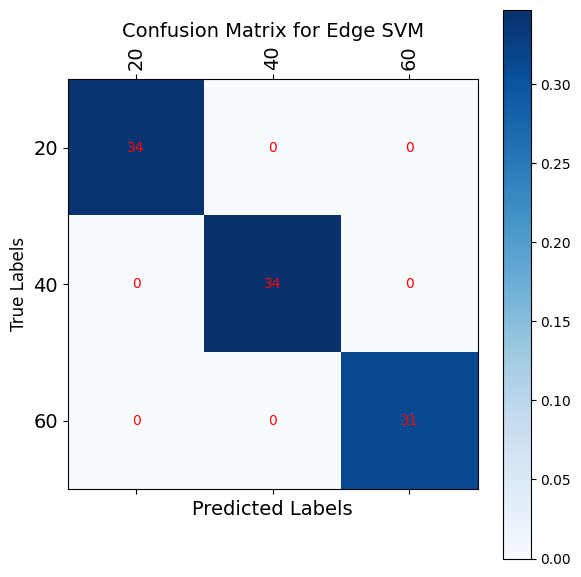

In [19]:
def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(y_train,axis=0)
    print(matrix.shape,len(true_labels),len(pred_labels))
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix/len(true_labels)

predictions = [y_pred]
model_names = ['Edge SVM']
num_classes = len(np.unique(y_train,axis=0))
un=np.unique(y_train,axis=0)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(6, 6))
labels=[ "20",  "40",  "60", "110", "130", "150", "200", "220", "240"]
for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(y_pred, y_test, num_classes=len(np.unique(y_train,axis=0)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{int(value*100)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([labels[un[j][0]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([labels[un[j][0]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/edgeConfusionSVM.pdf")
plt.show()

### Regression

In [16]:
alpha = 1.0  # Regularization parameter
# Fit and transform the label data
X_notall=np.concatenate([X20,X40[0:1],X60])
y_=np.concatenate([np.zeros(len(X20))+20,np.zeros(len(X40[0:1]))+40,np.zeros(len(X60))+60])
X_=X_notall.reshape(len(X_notall),-1).astype(np.uint8)
print(X_.shape,y_.shape)
X_test=X40.reshape(len(X40),-1).astype(np.uint8)
y_test=np.zeros(len(X40))+40
#X_train, X_test, y_train, y_test = train_test_split(X_, np.asarray(np.argmax(onehot_labels,axis=1)).astype(np.uint8), test_size=0.2, random_state=42)
# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_, y_)
predictions = np.round(ridge_model.predict(X_test))
print(predictions)
a=predictions.astype(np.int8)-y_test.astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-y_test))/len(predictions))

(481, 10000) (481,)
[40. 44. 43. 44. 44. 45. 45. 45. 45. 45. 49. 48. 49. 49. 49. 47. 48. 46.
 48. 45. 48. 49. 48. 48. 48. 47. 48. 47. 45. 45. 50. 48. 49. 48. 50. 49.
 48. 46. 47. 45. 51. 51. 51. 51. 50. 49. 48. 47. 45. 46. 51. 50. 51. 50.
 51. 49. 47. 47. 45. 43. 50. 51. 51. 52. 51. 51. 49. 49. 46. 46. 52. 52.
 52. 52. 51. 50. 49. 49. 47. 47. 50. 49. 50. 49. 50. 49. 49. 49. 49. 48.
 52. 51. 51. 51. 51. 51. 50. 50. 50. 49. 47. 48. 49. 50. 49. 50. 49. 48.
 48. 48. 51. 50. 51. 50. 50. 51. 50. 49. 48. 49. 40. 44. 43. 44. 44. 45.
 45. 45. 45. 45. 49. 48. 49. 49. 49. 47. 48. 46. 48. 45. 48. 49. 48. 48.
 48. 47. 48. 47. 45. 45. 50. 48. 49. 48. 50. 49. 48. 46. 47. 45. 51. 51.
 51. 51. 50. 49. 48. 47. 45. 46. 51. 50. 51. 50. 51. 49. 47. 47. 45. 43.
 50. 51. 51. 52. 51. 51. 49. 49. 46. 46. 52. 52. 52. 52. 51. 50. 49. 49.
 47. 47. 50. 49. 50. 49. 50. 49. 49. 49. 49. 48. 52. 51. 51. 51. 51. 51.
 50. 50. 50. 49. 47. 48. 49. 50. 49. 50. 49. 48. 48. 48. 51. 50. 51. 50.
 50. 51. 50. 49. 48. 49.]
Accur

In [17]:
alpha = 1.0  # Regularization parameter
# Fit and transform the label data
X_notall=np.concatenate([X20,X40[0:1],X60])
y_=np.concatenate([np.zeros(len(X20))+20,np.zeros(len(X40[0:1]))+40,np.zeros(len(X60))+60])
X_=X_notall.reshape(len(X_notall),-1).astype(np.uint8)
print(X_.shape,y_.shape)
X_test=X40.reshape(len(X40),-1).astype(np.uint8)
y_test=np.zeros(len(X40))+40
#X_train, X_test, y_train, y_test = train_test_split(X_, np.asarray(np.argmax(onehot_labels,axis=1)).astype(np.uint8), test_size=0.2, random_state=42)
# Define the Ridge regression model
ridge_model = LinearRegression()
ridge_model.fit(X_, y_)
predictions = np.round(ridge_model.predict(X_test))
print(predictions)
a=predictions.astype(np.int8)-y_test.astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-y_test))/len(predictions))

(481, 10000) (481,)
[40. 44. 43. 44. 44. 45. 45. 45. 45. 45. 49. 48. 49. 49. 49. 47. 48. 46.
 48. 45. 48. 49. 48. 48. 48. 47. 48. 47. 45. 45. 50. 48. 49. 48. 50. 49.
 48. 46. 47. 45. 51. 51. 51. 51. 50. 49. 48. 47. 45. 46. 51. 50. 51. 50.
 51. 49. 47. 47. 45. 43. 50. 51. 51. 52. 51. 51. 49. 49. 46. 46. 52. 52.
 52. 51. 51. 50. 49. 49. 47. 47. 50. 49. 50. 49. 50. 49. 49. 49. 49. 48.
 52. 51. 51. 51. 51. 51. 50. 50. 50. 49. 47. 48. 49. 50. 49. 50. 49. 48.
 48. 48. 51. 50. 51. 50. 50. 51. 50. 49. 48. 49. 40. 44. 43. 44. 44. 45.
 45. 45. 45. 45. 49. 48. 49. 49. 49. 47. 48. 46. 48. 45. 48. 49. 48. 48.
 48. 47. 48. 47. 45. 45. 50. 48. 49. 48. 50. 49. 48. 46. 47. 45. 51. 51.
 51. 51. 50. 49. 48. 47. 45. 46. 51. 50. 51. 50. 51. 49. 47. 47. 45. 43.
 50. 51. 51. 52. 51. 51. 49. 49. 46. 46. 52. 52. 52. 51. 51. 50. 49. 49.
 47. 47. 50. 49. 50. 49. 50. 49. 49. 49. 49. 48. 52. 51. 51. 51. 51. 51.
 50. 50. 50. 49. 47. 48. 49. 50. 49. 50. 49. 48. 48. 48. 51. 50. 51. 50.
 50. 51. 50. 49. 48. 49.]
Accur